In [42]:
!pip install h2o

In [43]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars
import pyarrow
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve

In [44]:
# ==================== 环境配置 ====================
try:
    import polars  # noqa
    import pyarrow  # noqa
    _multi_thread_support = True
except ImportError:
    print("警告：未安装 polars/pyarrow，将使用单线程模式")
    _multi_thread_support = False

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwrhs4rk3
  JVM stdout: /tmp/tmpwrhs4rk3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwrhs4rk3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_9wexco
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [45]:
# ==================== 数据加载 ====================
def load_data():
    try:
        df = pd.read_csv(
            "https://raw.githubusercontent.com/AI-is-out-there/data2lab/main/%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%203%20-%20%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20-%20%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.csv"
        )
    except UnicodeDecodeError:
        df = pd.read_csv(
            "https://raw.githubusercontent.com/AI-is-out-there/data2lab/main/%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%203%20-%20%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20-%20%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.csv"
        )

    # 确保目标变量是字符串类型
    df['Healthy_Status'] = df['Healthy_Status'].astype(str)
    return df


df = load_data()

In [46]:
# ==================== H2O数据处理 ====================
hf = h2o.H2OFrame(df)
hf['Healthy_Status'] = hf['Healthy_Status'].asfactor()
train, test = hf.split_frame(ratios=[0.8], seed=123)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
# ==================== AutoML训练 ====================
aml = H2OAutoML(
    max_models=10,
    seed=888,
    exclude_algos=["XGBoost"],
    max_runtime_secs=300,
    verbosity="info"
)
aml.train(x=hf.columns[:-1], y='Healthy_Status', training_frame=train)

AutoML progress: |
08:30:11.230: Project: AutoML_1_20250514_83010
08:30:11.239: 5-fold cross-validation will be used.
08:30:11.240: Setting stopping tolerance adaptively based on the training frame: 0.011167086836213468
08:30:11.248: Build control seed: 888
08:30:11.250: training frame: Frame key: AutoML_1_20250514_83010_training_py_17_sid_aceb    cols: 36    rows: 8019  chunks: 1    size: 1085478  checksum: 6264962419546497032
08:30:11.250: validation frame: NULL
08:30:11.250: leaderboard frame: NULL
08:30:11.255: blending frame: NULL
08:30:11.255: response column: Healthy_Status
08:30:11.255: fold column: null
08:30:11.255: weights column: null
08:30:11.423: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (7g, 10w

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20250514_83010


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    312                312                         460904                 3            7            6.97756       4             73            30.016

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 7.61975720259492e-21
RMSE: 8.729122065016e-11
LogLoss: 3.647728075383539e-12
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9999999999896884
       0     1     Error    Rate
-----  ----  ----  -------  ------------
0      6398  0     0        (0.0/6398.0)
1      0     1621  0        (0.0/1621.0)
Total  6398  1621  0        (0.0/8019.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       1            1        0
max f2                       1            1        0
max f0point5                 1            1        0
max accuracy                 1            1        0
max precision                1            1        0
max recall                   1            1        0
max specificity              1            1        0
max absolute_mcc             1            1        0
max min_per_class_accuracy   1            1        0
max mean_per_class_accuracy  1            1        0
max tns                      1            6398     0
max fns                      1            0        0
max fps                      2.98819e-14  6398     399
max tps                      1            1621     0
max tnr                      1            1        0
max fnr                      1            0        0
max fpr                      2.98819e-14  1        399
max tpr                      1            1        0

Gains/Lift Table: Avg response rate: 20.21 %, avg score: 20.21 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.010101                    1                  4.94695  4.94695            1                1            1                           1                   0.0499692       0.0499692                  394.695  394.695            0.0499692
2        0.0200773                   1                  4.94695  4.94695            1                1            1                           1                   0.0493523       0.0993214                  394.695  394.695            0.0993214
3        0.0300536                   1                  4.94695  4.94695            1                1            1                           1                   0.0493523       0.148674                   394.695  394.695            0.148674
4        0.0405287                   1                  4.94695  4.94695            1                1            1                           1                   0.0518199       0.200494                   394.695  394.695            0.200494
5        0.0500062                   1                  4.94695  4.94695            1                1            1                           1                   0.0468846       0.247378                   394.695  394.695            0.247378
6        0.1

In [48]:
# ==================== 数据转换 ====================
def convert_h2o_to_pdf(frame):
    try:
        return frame.as_data_frame(use_multi_thread=_multi_thread_support)
    except Exception as e:
        print(f"多线程转换失败: {str(e)}, 回退到单线程")
        return frame.as_data_frame()


test_df = convert_h2o_to_pdf(test)
pred = aml.leader.predict(test)
pred_df = convert_h2o_to_pdf(pred)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [49]:
# ==================== 核心指标计算 ====================
cm = confusion_matrix(test_df['Healthy_Status'], pred_df['predict'])
f1 = f1_score(test_df['Healthy_Status'], pred_df['predict'], average='binary')

In [50]:
# ==================== 可视化增强 ====================
plt.rcParams.update({'font.size': 12, 'figure.dpi': 150})

In [51]:
# 1. 混淆矩阵（兼容分类标签）
def plot_confusion_matrix(cm):
    classes = sorted(test_df['Healthy_Status'].unique())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f'Confusion Matrix\nF1 Score: {f1:.4f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


In [52]:
# 2. 特征分布图（修复调色板问题）
def plot_feature_distribution():
    features = df.columns[:-1]  # 获取特征列
    n_features = len(features)
    n_cols = 3  # 每行显示3个子图
    n_rows = (n_features + n_cols - 1) // n_cols  # 计算需要的行数

    plt.figure(figsize=(14, 5 * n_rows))  # 根据行数调整画布高度

    # 动态获取类别和颜色
    categories = sorted(df['Healthy_Status'].unique())
    palette = {cat: color for cat, color in zip(categories, ['tomato', 'limegreen'])}

    for idx, col in enumerate(features):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.violinplot(
            x='Healthy_Status',
            y=col,
            data=df,
            hue='Healthy_Status',
            palette=palette,
            legend=False
        )
        plt.title(col, fontsize=10)
        plt.xticks(ticks=[0, 1], labels=categories)

    # 隐藏多余的空子图
    for j in range(n_features, n_rows * n_cols):
        plt.subplot(n_rows, n_cols, j + 1)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    plt.show()


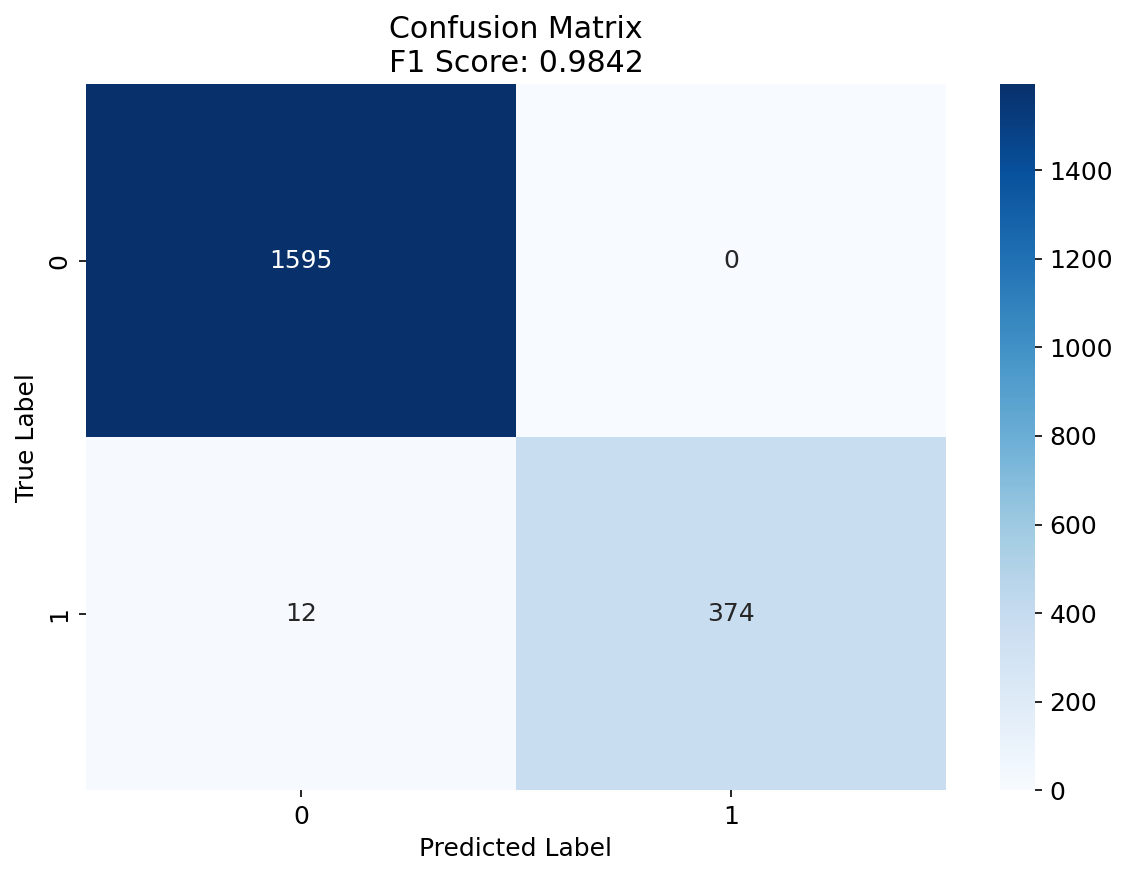

<ipython-input-52-a73fcd679da8>:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


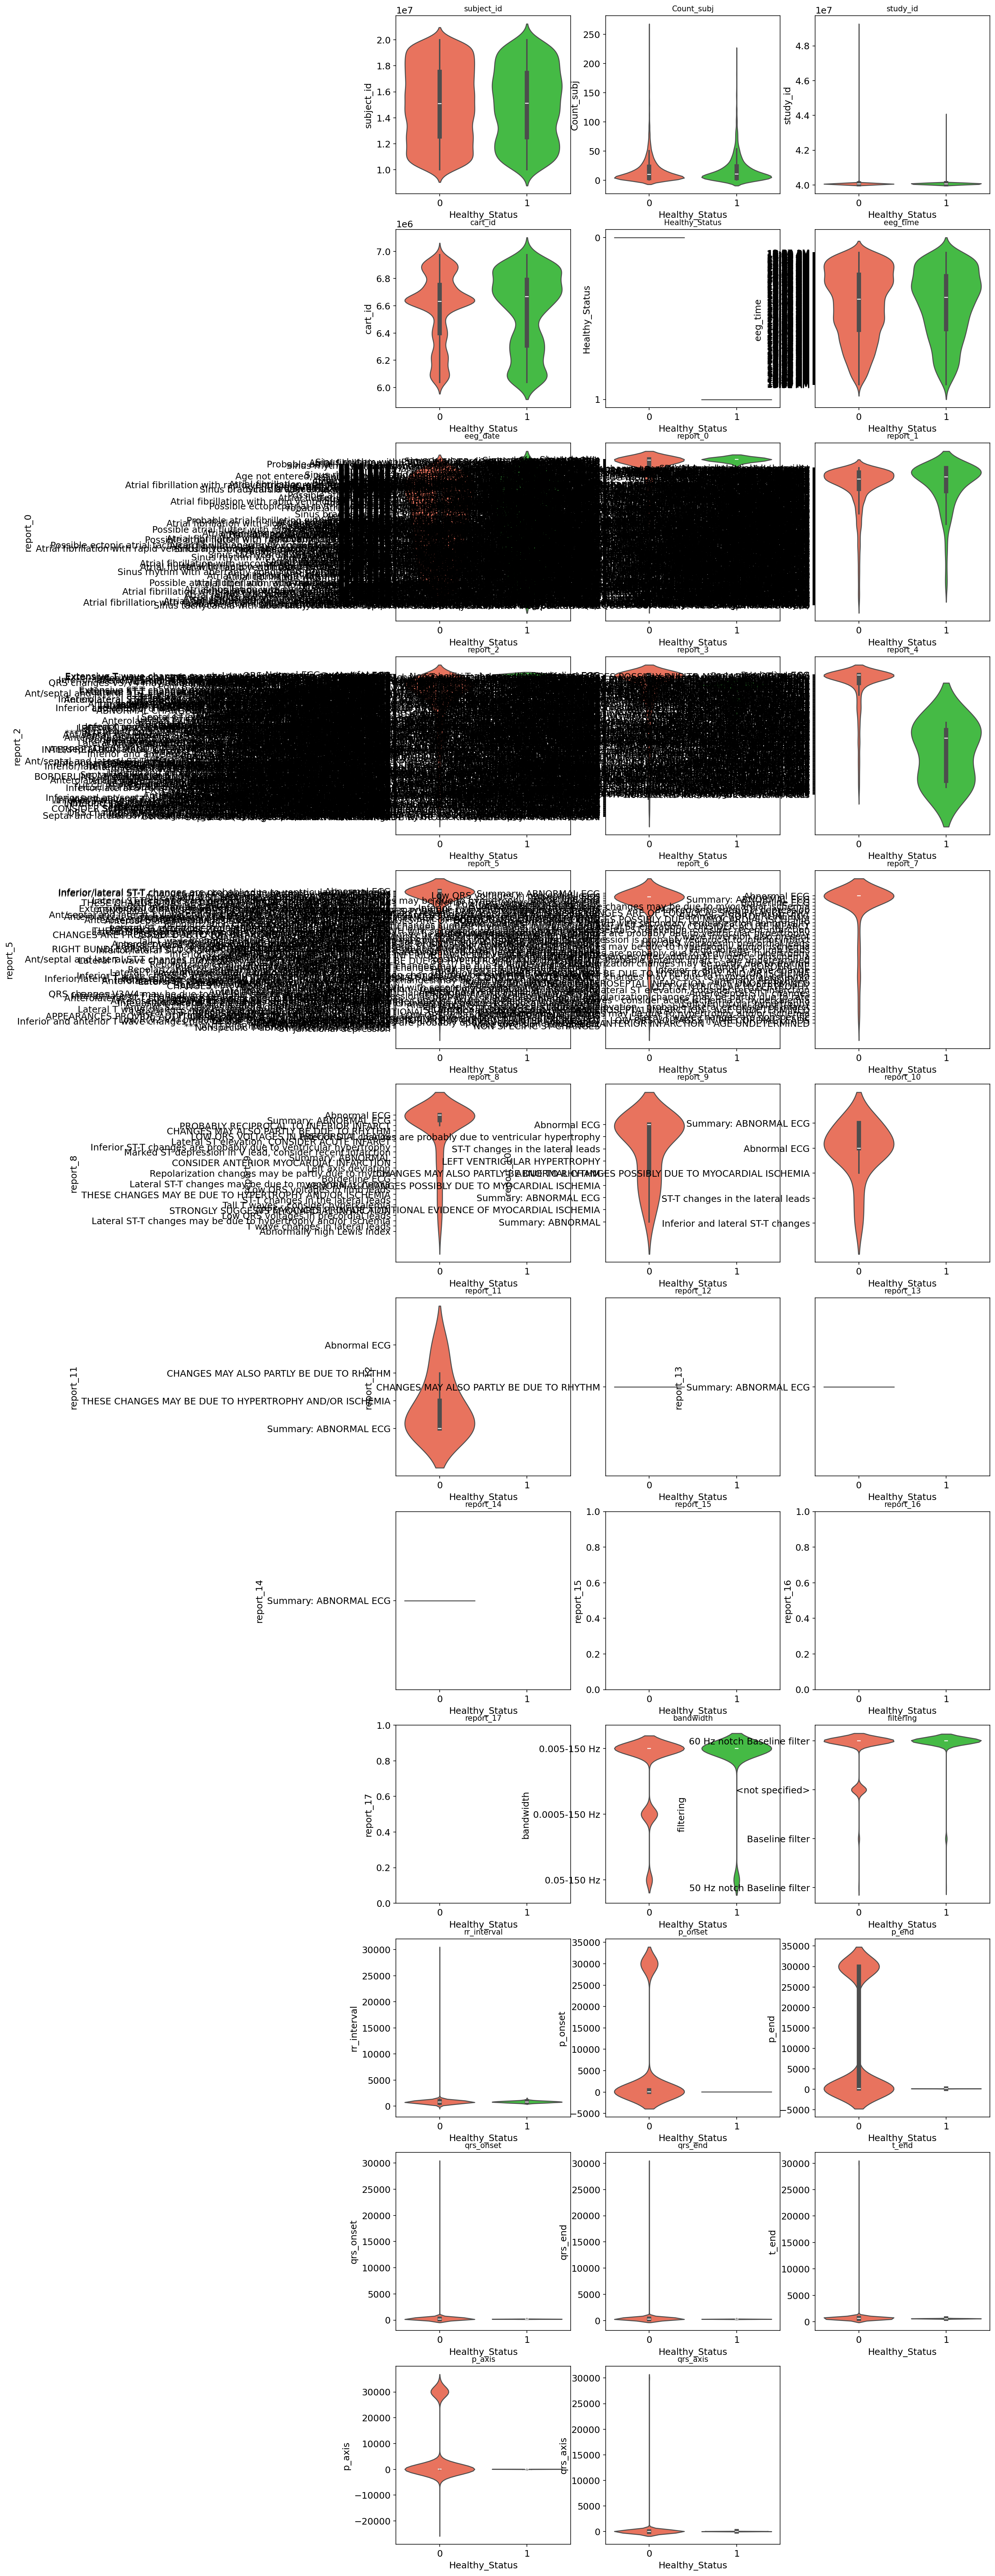

In [53]:
# ==================== 执行可视化 ====================
plot_confusion_matrix(cm)
plot_feature_distribution()


In [54]:
# ==== 新增输出部分 ====
# 1. 输出最佳模型信息
best_model = aml.leader
print("\n" + "="*50)
print(f"最佳模型：{best_model.model_id}")
print("模型参数摘要：")
print(best_model.params.keys())  # 显示可用的参数配置
print("="*50 + "\n")

# 2. 显示训练模型列表
leaderboard = aml.leaderboard
print("模型排行榜：")
print(leaderboard.head())
print("\n训练的模型类型分布：")
model_types = [m.split("_")[0] for m in leaderboard.as_data_frame()['model_id']]
print(pd.Series(model_types).value_counts())



最佳模型：GBM_2_AutoML_1_20250514_83010
模型参数摘要：
dict_keys(['model_id', 'training_frame', 'validation_frame', 'nfolds', 'keep_cross_validation_models', 'keep_cross_validation_predictions', 'keep_cross_validation_fold_assignment', 'score_each_iteration', 'score_tree_interval', 'fold_assignment', 'fold_column', 'response_column', 'ignored_columns', 'ignore_const_cols', 'offset_column', 'weights_column', 'balance_classes', 'class_sampling_factors', 'max_after_balance_size', 'max_confusion_matrix_size', 'ntrees', 'max_depth', 'min_rows', 'nbins', 'nbins_top_level', 'nbins_cats', 'r2_stopping', 'stopping_rounds', 'stopping_metric', 'stopping_tolerance', 'max_runtime_secs', 'seed', 'build_tree_one_node', 'learn_rate', 'learn_rate_annealing', 'distribution', 'quantile_alpha', 'tweedie_power', 'huber_alpha', 'checkpoint', 'sample_rate', 'sample_rate_per_class', 'col_sample_rate', 'col_sample_rate_change_per_level', 'col_sample_rate_per_tree', 'min_split_improvement', 'histogram_type', 'max_abs_leaf

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [55]:
# ==================== 资源清理 ====================
h2o.cluster().shutdown(prompt=False)

H2O session _sid_aceb closed.
